## Business Understanding

- Goal: Predict the net hour electrical energr output (PE) based on the features given.

## Set-up Environment

In [1]:
import findspark
findspark.init()

In [2]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import pandas_profiling as pp

import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql import types 
from pyspark.sql.types import *
from pyspark.ml.feature import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.regression import DecisionTreeRegressor, DecisionTreeRegressionModel
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.regression import GBTRegressor, GBTRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [3]:
sc = SparkContext()

In [4]:
spark = SparkSession.builder.appName('electric').getOrCreate()

## Data loading

In [5]:
df = pd.read_excel('CCPP\Folds5x2_pp.xlsx', sheet_name = 'Sheet1')

In [6]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


## Data Understanding

#### Data Collection
- The dataset collected from over 6 years (2006-2011).
- It's composed of 9568 entries collected when the CCPP is set to work with a full load over 674 different days.

#### Data Understanding
- There are 4 features in the dataset:
    - Temperature (T) in the range 1.81°C and 37.11°C
    - Ambient Pressure (AP) in the range 992.89-1033.30 milibar
    - Relative Humidity (RH) in the range 25.56% to 100.16%
    - Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
    - Net hourly electrical energy output (EP) 420.26-495.76 MW
- The input variables affect full load electrical power output (PE), which is considered as the target variable in the dataset and corresponds to average hourly full load electrical power output data received from the control system when the power plant was at base load.

In [8]:
schema = StructType([
    StructField("AT", DoubleType(), True),
    StructField("V", DoubleType(), True),
    StructField("AP", DoubleType(), True),
    StructField("RH", DoubleType(), True),
    StructField("PE", DoubleType(), True)])
electric = spark.createDataFrame(df, schema)

In [9]:
electric.printSchema()

root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- PE: double (nullable = true)



In [10]:
print('Total row od the dataset:', electric.count())

Total row od the dataset: 9568


In [11]:
electric.show(5)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
+-----+-----+-------+-----+------+
only showing top 5 rows



## Data preparation

### Data cleaning

In [12]:
#nan checking
electric.select([count(when(isnan(c), c)).alias(c) for c in electric.columns]).toPandas().T

,0
AT,0
V,0
AP,0
RH,0
PE,0


- There is no nan value in the dataset

In [13]:
#null checking
electric.select([count(when(col(c).isNull(), c)).alias(c) for c in electric.columns]).toPandas().T

,0
AT,0
V,0
AP,0
RH,0
PE,0


There is no null value in the data

In [14]:
#Duplicate value
print('Total of duplicate row:', electric.count() - electric.distinct().count())

Total of duplicate row: 41


There is 41 duplicate row => del it.

In [15]:
electric = electric.dropDuplicates()

In [16]:
print('Total row after drop duplicate value:',electric.count())

Total row after drop duplicate value: 9527


### Single variable analysis

In [17]:
electric.toPandas().profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
electric.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|                AT|                 V|                AP|                RH|                PE|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              9527|              9527|              9527|              9527|              9527|
|   mean|19.658225044610045|54.293420804030674|1013.2370840768343| 73.33495119135091| 454.3359095203109|
| stddev| 7.444397078136744| 12.68630900937443| 5.940526064757286|14.607513252912073|17.039080412855846|
|    min|              1.81|             25.36|            992.89|             25.56|            420.26|
|    max|             37.11|             81.56|            1033.3|            100.16|            495.76|
+-------+------------------+------------------+------------------+------------------+------------------+



- The describe result showed that:
    - There is a difference between features value range. 
    - The standard deviation seem acceptable for dataset with 9k entries.
    - The dataset featues count are the same.

All of variable in dataset are double type (numeric), so I need to make a numerical analysis

========== AT ==========
+-------+------------------+
|summary|                AT|
+-------+------------------+
|  count|              9527|
|   mean|19.658225044610045|
| stddev| 7.444397078136744|
|    min|              1.81|
|    25%|             13.52|
|    50%|             20.34|
|    75%|             25.71|
|    max|             37.11|
+-------+------------------+

+--------------------+-------------------+
|        skewness(AT)|       kurtosis(AT)|
+--------------------+-------------------+
|-0.13608548725361627|-1.0327816502212657|
+--------------------+-------------------+



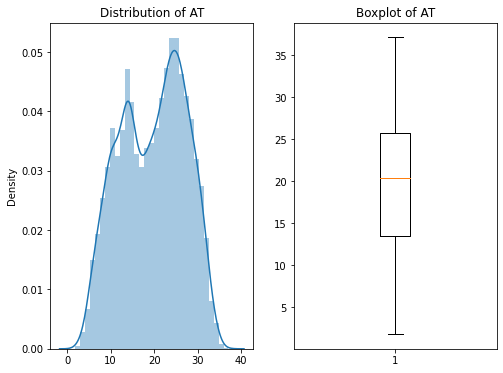

========== V ==========
+-------+------------------+
|summary|                 V|
+-------+------------------+
|  count|              9527|
|   mean|54.293420804030674|
| stddev| 12.68630900937443|
|    min|             25.36|
|    25%|             41.74|
|    50%|             52.08|
|    75%|             66.51|
|    max|             81.56|
+-------+------------------+

+------------------+------------------+
|       skewness(V)|       kurtosis(V)|
+------------------+------------------+
|0.1967877913445619|-1.443630069217891|
+------------------+------------------+



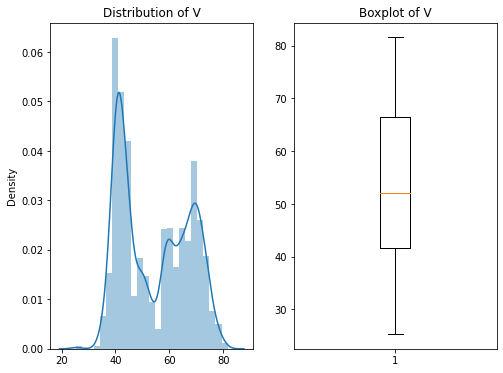

========== AP ==========
+-------+------------------+
|summary|                AP|
+-------+------------------+
|  count|              9527|
|   mean|1013.2370840768343|
| stddev| 5.940526064757286|
|    min|            992.89|
|    25%|           1009.07|
|    50%|           1012.92|
|    75%|            1017.2|
|    max|            1033.3|
+-------+------------------+

+-----------------+-------------------+
|     skewness(AP)|       kurtosis(AP)|
+-----------------+-------------------+
|0.273802510565073|0.10348605174118841|
+-----------------+-------------------+



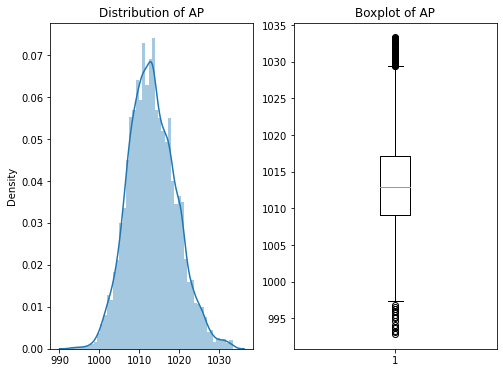

========== RH ==========
+-------+------------------+
|summary|                RH|
+-------+------------------+
|  count|              9527|
|   mean| 73.33495119135091|
| stddev|14.607513252912073|
|    min|             25.56|
|    25%|             63.36|
|    50%|              75.0|
|    75%|             84.85|
|    max|            100.16|
+-------+------------------+

+-------------------+-------------------+
|       skewness(RH)|       kurtosis(RH)|
+-------------------+-------------------+
|-0.4350699745816631|-0.4409130938478141|
+-------------------+-------------------+



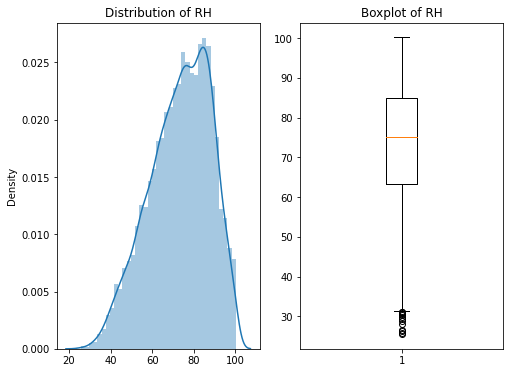

========== PE ==========
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              9527|
|   mean| 454.3359095203109|
| stddev|17.039080412855846|
|    min|            420.26|
|    25%|            439.75|
|    50%|            451.51|
|    75%|            468.36|
|    max|            495.76|
+-------+------------------+

+------------------+-------------------+
|      skewness(PE)|       kurtosis(PE)|
+------------------+-------------------+
|0.3057423646291882|-1.0454726712616023|
+------------------+-------------------+



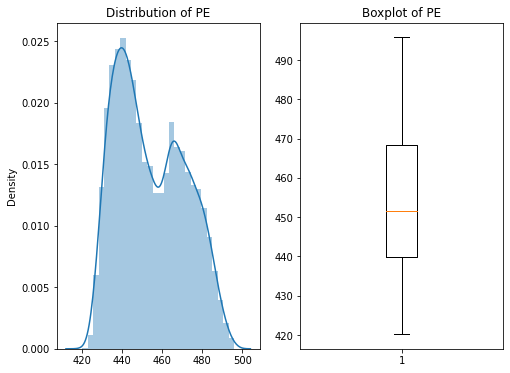

In [19]:
for cols in electric.columns:
    print('='*10, cols, '='*10)
    electric.select(cols).summary().show()
    electric.select(skewness(cols),kurtosis(cols)).show()
    
    plt.figure(figsize = (8,6))
    plt.subplot(1,2,1)
    sns.distplot(electric.select(cols).toPandas())
    plt.title('Distribution of '+cols)
    
    plt.subplot(1,2,2)
    plt.boxplot(electric.select(cols).toPandas())
    plt.title('Boxplot of '+cols)
    plt.show()

- Result showed that:
    - All features are numerical.
    - Left skew features contain AT (weak) and RH(strong), while the rest are right skew.
    - There is one feature have outliers - AP
    - The features's value have a variety of range [1.96, 1033.3] we need to scale the data to reduce its difference.

## Multivariable analysis

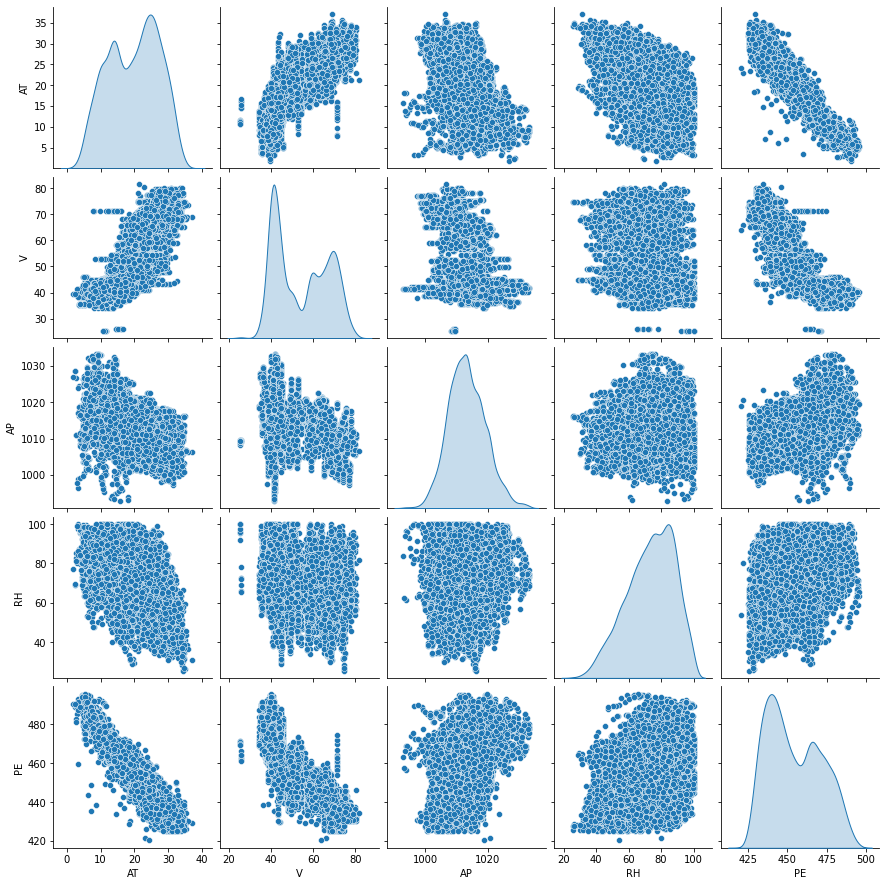

In [20]:
sns.pairplot(electric.toPandas(), diag_kind = 'kde', palette = 'tab10')

Most of the features have a strong correlation with the output - PE, and also those input features have a strong correlation with each other, except RH and AP.

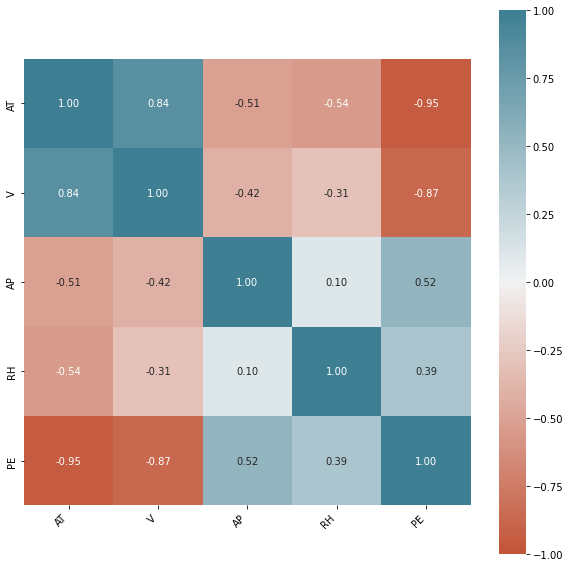

In [21]:
corr = electric.toPandas().corr()

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr,vmin=-1, vmax=1, center=0,
    annot=True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
     fmt='.2f'
)
ax.set_xticklabels( # adding axes values
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

- One again, we can see the correlated between features clearly:
    - PE have all 4 input features correlated with it:
        - AT and V have strong negative corellated. But this pair: AT and V also have strong possitive corr. (Take 1)
        - AP and RH have weak corr to PE, but these 2 feature does not have corr to each other.
    - With the input features:
        - As I mentioned above: AT and V have strong possitive corr.
        - AP have weak negative corr with AT and V. While RH have the same case but with AT.
        - AP and RH does not have corr.

In [22]:
def outliers_detect(f):
    electrics = electric.toPandas()
    Q1 = np.percentile(electrics[f], 25)
    Q3 = np.percentile(electrics[f], 75)

    upper_outlier = electrics[electrics[f] > (Q3 + 1.5*(Q3 - Q1))].shape[0]
    lower_outlier = electrics[electrics[f] < (Q1 - 1.5*(Q3 - Q1))].shape[0]
    print('Percentage of outlier in dataset:', (((upper_outlier+lower_outlier)/electrics.shape[0])*100),'%')

In order to transform/scale the data, I must delete the outliers because this dataset is a combined of right and left skew features. So that if we need to scale the data minmax or standard, the outliers need to be disapeared.

In [23]:
outliers_detect('AP')

Percentage of outlier in dataset: 0.9551800146950772 %


The outliers accounted for nearly 1% of the dataset => deleted it.

In [24]:
#Caculate values used for outlier filtering
mean_val = electric.agg({'AP':'mean'}).collect()[0][0]
std_val = electric.agg({'AP':'stddev'}).collect()[0][0]

#create three std - lower and upper bounds for filter outlier
lower_bound = mean_val - (3 * std_val)
upper_bound = mean_val + (3 * std_val)

#filter the data to fit between lower and upper bound
electric = electric.where((electric['AP'] < upper_bound) & (electric['AP'] > lower_bound))

In [25]:
print('Total row of data after delete outliers:', electric.count())

Total row of data after delete outliers: 9476


### Data transformation

In [26]:
def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_values = df.agg({col: 'max'}).collect()[0][0]
        min_values = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                      (df[col] - min_values) / (max_values - min_values))
    return df

The data need to devide into 2 dataset: original and scaled data for building model. Then I will select the best model fit with those 2 dataset.

In [27]:
#create a scale dataset from original data
electric_scale = electric

In [28]:
electric_scale.show(5)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|24.54|60.29|1017.42|58.94|447.67|
|10.59|42.49|1009.59|77.36|477.49|
| 26.7|66.56|1005.31|71.97|430.21|
|21.24|41.67| 1012.6|49.27|459.81|
|27.74|74.78|1010.05|60.82|436.87|
+-----+-----+-------+-----+------+
only showing top 5 rows



In [29]:
col_to_scale = ['AT', 'V', 'AP', 'RH', 'PE']
electric_scale = min_max_scaler(electric_scale, col_to_scale)

In [30]:
electric_scale.show(5)

+-----+-----+-------+-----+------+-------------------+-------------------+------------------+-------------------+-------------------+
|   AT|    V|     AP|   RH|    PE|          scaled_AT|           scaled_V|         scaled_AP|          scaled_RH|          scaled_PE|
+-----+-----+-------+-----+------+-------------------+-------------------+------------------+-------------------+-------------------+
|24.54|60.29|1017.42|58.94|447.67| 0.6439093484419264| 0.6215302491103203| 0.617829021372327|0.44745308310991955| 0.3630463576158944|
|10.59|42.49|1009.59|77.36|477.49|0.24872521246458923| 0.3048042704626335|0.3976377952755908| 0.6943699731903485| 0.7580132450331128|
| 26.7|66.56|1005.31|71.97|430.21| 0.7050991501416431| 0.7330960854092526|0.2772778402699639|  0.622117962466488|0.13178807947019852|
|21.24|41.67| 1012.6|49.27|459.81| 0.5504249291784703|0.29021352313167265|0.4822834645669292|0.31782841823056307| 0.5238410596026492|
|27.74|74.78|1010.05|60.82|436.87| 0.7345609065155808| 0.87935

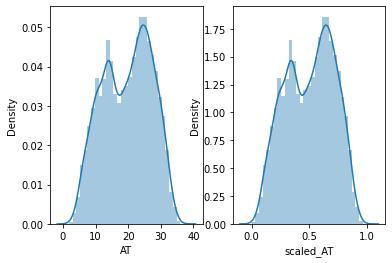

+-------------------+--------------------+------------------+-------------------+
|       skewness(AT)| skewness(scaled_AT)|      kurtosis(AT)|kurtosis(scaled_AT)|
+-------------------+--------------------+------------------+-------------------+
|-0.1443029397342514|-0.14430293973425162|-1.023428183758752|-1.0234281837587464|
+-------------------+--------------------+------------------+-------------------+



In [31]:
plt.subplot(1,2,1)
sns.distplot(electric_scale.toPandas()['AT'])
print()
plt.subplot(1,2,2)
sns.distplot(electric_scale.toPandas()['scaled_AT'])
plt.show()
electric_scale.select(skewness('AT'),skewness('scaled_AT'),kurtosis('AT'), kurtosis('scaled_AT')).show()

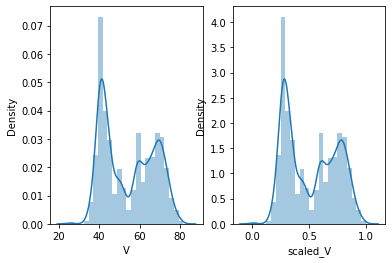

+------------------+-------------------+-------------------+-------------------+
|       skewness(V)| skewness(scaled_V)|        kurtosis(V)| kurtosis(scaled_V)|
+------------------+-------------------+-------------------+-------------------+
|0.1872826559694657|0.18728265596946525|-1.4446848559042347|-1.4446848559042416|
+------------------+-------------------+-------------------+-------------------+



In [32]:
plt.subplot(1,2,1)
sns.distplot(electric_scale.toPandas()['V'])
print()
plt.subplot(1,2,2)
sns.distplot(electric_scale.toPandas()['scaled_V'])
plt.show()
electric_scale.select(skewness('V'),skewness('scaled_V'),kurtosis('V'), kurtosis('scaled_V')).show()

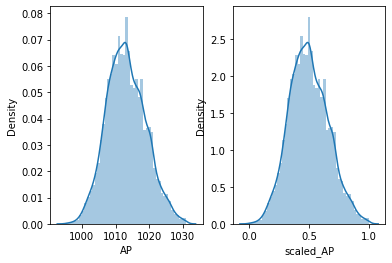

+-------------------+-------------------+--------------------+--------------------+
|       skewness(AP)|skewness(scaled_AP)|        kurtosis(AP)| kurtosis(scaled_AP)|
+-------------------+-------------------+--------------------+--------------------+
|0.21175905427804406|0.21175905427804614|-0.15945999837529623|-0.15945999837528557|
+-------------------+-------------------+--------------------+--------------------+



In [33]:
plt.subplot(1,2,1)
sns.distplot(electric_scale.toPandas()['AP'])
print()
plt.subplot(1,2,2)
sns.distplot(electric_scale.toPandas()['scaled_AP'])
plt.show()
electric_scale.select(skewness('AP'),skewness('scaled_AP'),kurtosis('AP'), kurtosis('scaled_AP')).show()

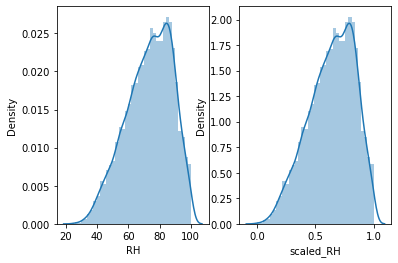

+--------------------+-------------------+--------------------+-------------------+
|        skewness(RH)|skewness(scaled_RH)|        kurtosis(RH)|kurtosis(scaled_RH)|
+--------------------+-------------------+--------------------+-------------------+
|-0.43377633153766937|-0.4337763315376688|-0.44907499983467947|-0.4490749998346879|
+--------------------+-------------------+--------------------+-------------------+



In [34]:
plt.subplot(1,2,1)
sns.distplot(electric_scale.toPandas()['RH'])
print()
plt.subplot(1,2,2)
sns.distplot(electric_scale.toPandas()['scaled_RH'])
plt.show()
electric_scale.select(skewness('RH'),skewness('scaled_RH'),kurtosis('RH'), kurtosis('scaled_RH')).show()

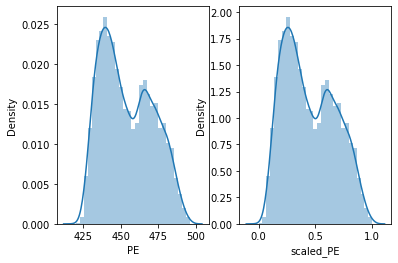

+-------------------+-------------------+-------------------+-------------------+
|       skewness(PE)|skewness(scaled_PE)|       kurtosis(PE)|kurtosis(scaled_PE)|
+-------------------+-------------------+-------------------+-------------------+
|0.31626677364211775|0.31626677364211747|-1.0321184134123884| -1.032118413412393|
+-------------------+-------------------+-------------------+-------------------+



In [35]:
plt.subplot(1,2,1)
sns.distplot(electric_scale.toPandas()['PE'])
print()
plt.subplot(1,2,2)
sns.distplot(electric_scale.toPandas()['scaled_PE'])
plt.show()
electric_scale.select(skewness('PE'),skewness('scaled_PE'),kurtosis('PE'), kurtosis('scaled_PE')).show()

The data after scale does not change much.

## Modeling & Evaluation

## Linear Regression

### Model with original data

In [36]:
def linear_regression(data, label):
    train_data, test_data = data.randomSplit([0.8, 0.2])
    
    print('-'*30, 'Train data describe', '-'*30)
    train_data.describe().show()
    print('-'*30, 'Test data describe', '-'*30)
    test_data.describe().show()
    
    lr = LinearRegression(featuresCol='features', labelCol = label)
    
    lrModel = lr.fit(train_data)
    print('-'*30, 'Coef and Intercept', '-'*30)
    print('Coefficients: {} intercept: {}'.format(lrModel.coefficients, lrModel.intercept))
    train_results = lrModel.evaluate(train_data)
    test_results = lrModel.evaluate(test_data)
    print('-'*30, 'Residual', '-'*30)
    test_results.residuals.show(5)
    test_model = lrModel.transform(test_data)

    #Inspect results
    print('-'*30, 'Model result', '-'*30)
    test_model.select('prediction', label).show(5)
    print('-'*30, 'Model evaluation', '-'*30)
    print('RMSE train: {}'.format(train_results.rootMeanSquaredError))
    print('RMSE test: {}'.format(test_results.rootMeanSquaredError))
    print('\n')
    print('MSE train: {}'.format(train_results.meanSquaredError))
    print('MSE test: {}'.format(test_results.meanSquaredError))
    print('\n')
    print('R2 train: {}'.format(train_results.r2))
    print('R2 test: {}'.format(test_results.r2))

In [37]:
assembler = VectorAssembler(
    inputCols = ['AT', 'V', 'AP', 'RH'],
                 outputCol = 'features' #input
)
data_pre = assembler.transform(electric)

In [38]:
data_pre.select('features').show(2,False)

+---------------------------+
|features                   |
+---------------------------+
|[24.54,60.29,1017.42,58.94]|
|[10.59,42.49,1009.59,77.36]|
+---------------------------+
only showing top 2 rows



In [39]:
final_data = data_pre.select('features', 'PE')
final_data.count()

9476

In [40]:
final_data.show(5)

+--------------------+------+
|            features|    PE|
+--------------------+------+
|[24.54,60.29,1017...|447.67|
|[10.59,42.49,1009...|477.49|
|[26.7,66.56,1005....|430.21|
|[21.24,41.67,1012...|459.81|
|[27.74,74.78,1010...|436.87|
+--------------------+------+
only showing top 5 rows



In [41]:
linear_regression(final_data, 'PE')

------------------------------ Train data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              7625|
|   mean| 454.1410504918034|
| stddev|16.993478074635938|
|    min|            421.57|
|    max|            495.76|
+-------+------------------+

------------------------------ Test data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              1851|
|   mean| 454.5867314964884|
| stddev|17.098799359233567|
|    min|            420.26|
|    max|            494.39|
+-------+------------------+

------------------------------ Coef and Intercept ------------------------------
Coefficients: [-1.9806605343327437,-0.2340171993072273,0.06494411094450529,-0.16102170041924158] intercept: 452.0265006656247
------------------------------ Residual ------------------------------
+-------------------+
|          re

### Model with original data - Select relevant feature

In [42]:
assembler = VectorAssembler(
    inputCols = ['AT', 'AP', 'RH'],
                 outputCol = 'features' #input
)
data_pre = assembler.transform(electric)

In [43]:
final_data1 = data_pre.select('features', 'PE')
final_data1.count()

9476

In [44]:
final_data1.show(5)

+--------------------+------+
|            features|    PE|
+--------------------+------+
|[24.54,1017.42,58...|447.67|
|[10.59,1009.59,77...|477.49|
|[26.7,1005.31,71.97]|430.21|
|[21.24,1012.6,49.27]|459.81|
|[27.74,1010.05,60...|436.87|
+--------------------+------+
only showing top 5 rows



In [45]:
linear_regression(final_data1, 'PE')

------------------------------ Train data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              7618|
|   mean| 454.2546954581257|
| stddev|17.079928296191824|
|    min|            420.26|
|    max|            495.76|
+-------+------------------+

------------------------------ Test data describe ------------------------------
+-------+-----------------+
|summary|               PE|
+-------+-----------------+
|  count|             1858|
|   mean|454.1190958019378|
| stddev|16.74567155481461|
|    min|           425.16|
|    max|           495.23|
+-------+-----------------+

------------------------------ Coef and Intercept ------------------------------
Coefficients: [-2.385436851373061,0.03152125604867345,-0.206448656766752] intercept: 484.46977178058694
------------------------------ Residual ------------------------------
+------------------+
|         residuals|
+------------------+
| 5

The result after select relevant feature give the same performance like select the whole feature

### Model with transformed data

In [46]:
assembler = VectorAssembler(
    inputCols = ['scaled_AT', 'scaled_V', 'scaled_AP', 'scaled_RH'],
                 outputCol = 'features' #input
)
data_pre_scale = assembler.transform(electric_scale)

In [47]:
data_pre_scale.select('features').show(2,False)

+------------------------------------------------------------------------------+
|features                                                                      |
+------------------------------------------------------------------------------+
|[0.6439093484419264,0.6215302491103203,0.617829021372327,0.44745308310991955] |
|[0.24872521246458923,0.3048042704626335,0.3976377952755908,0.6943699731903485]|
+------------------------------------------------------------------------------+
only showing top 2 rows



In [48]:
final_data_scale = data_pre_scale.select('features', 'scaled_PE')
final_data_scale.count()

9476

In [49]:
final_data_scale.show(5)

+--------------------+-------------------+
|            features|          scaled_PE|
+--------------------+-------------------+
|[0.64390934844192...| 0.3630463576158944|
|[0.24872521246458...| 0.7580132450331128|
|[0.70509915014164...|0.13178807947019852|
|[0.55042492917847...| 0.5238410596026492|
|[0.73456090651558...|0.22000000000000017|
+--------------------+-------------------+
only showing top 5 rows



In [50]:
linear_regression(final_data_scale, 'scaled_PE')

------------------------------ Train data describe ------------------------------
+-------+--------------------+
|summary|           scaled_PE|
+-------+--------------------+
|  count|                7594|
|   mean|    0.44953520293993|
| stddev| 0.22490919032993986|
|    min|0.017350993377483474|
|    max|                 1.0|
+-------+--------------------+

------------------------------ Test data describe ------------------------------
+-------+-------------------+
|summary|          scaled_PE|
+-------+-------------------+
|  count|               1882|
|   mean| 0.4514158532208236|
| stddev|0.22718648938749406|
|    min|                0.0|
|    max| 0.9886092715231787|
+-------+-------------------+

------------------------------ Coef and Intercept ------------------------------
Coefficients: [-0.9289803902201191,-0.17303162779056588,0.025906392170471762,-0.15900310568135723] intercept: 1.0995137540678157
------------------------------ Residual ------------------------------
+----

The result showed that performance with scaled data have a better performance than original data. Although R2 increased a little bit, but RMSE and MSE have reduced alot.

### Model with scaled data and relevant features

In [51]:
assembler = VectorAssembler(
    inputCols = ['scaled_AT', 'scaled_AP', 'scaled_RH'],
                 outputCol = 'features' #input
)
data_pre_scale1 = assembler.transform(electric_scale)

data_pre_scale1.select('features').show(2,False)

final_data_scale1 = data_pre_scale1.select('features', 'scaled_PE')
final_data_scale1.count()

final_data_scale1.show(5)

+-----------------------------------------------------------+
|features                                                   |
+-----------------------------------------------------------+
|[0.6439093484419264,0.617829021372327,0.44745308310991955] |
|[0.24872521246458923,0.3976377952755908,0.6943699731903485]|
+-----------------------------------------------------------+
only showing top 2 rows

+--------------------+-------------------+
|            features|          scaled_PE|
+--------------------+-------------------+
|[0.64390934844192...| 0.3630463576158944|
|[0.24872521246458...| 0.7580132450331128|
|[0.70509915014164...|0.13178807947019852|
|[0.55042492917847...| 0.5238410596026492|
|[0.73456090651558...|0.22000000000000017|
+--------------------+-------------------+
only showing top 5 rows



In [52]:
linear_regression(final_data_scale1, 'scaled_PE')

------------------------------ Train data describe ------------------------------
+-------+-------------------+
|summary|          scaled_PE|
+-------+-------------------+
|  count|               7543|
|   mean|0.44957101580079983|
| stddev|0.22577948647126225|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

------------------------------ Test data describe ------------------------------
+-------+--------------------+
|summary|           scaled_PE|
+-------+--------------------+
|  count|                1933|
|   mean|  0.4512264845845766|
| stddev|  0.2237318320265654|
|    min|0.017350993377483474|
|    max|  0.9887417218543051|
+-------+--------------------+

------------------------------ Coef and Intercept ------------------------------
Coefficients: [-1.1124607051999535,0.015025764387392056,-0.2042641813173195] intercept: 1.136979078642787
------------------------------ Residual ------------------------------
+--------------------+
|    

- The linear model give the good result in 4 cases.
- All cases have r2 above 92%.

## Decisiontree Regression

In [53]:
def tree_regression(data, label):
    train_data, test_data = data.randomSplit([0.8, 0.2])
    
    print('-'*30, 'Train data describe', '-'*30)
    train_data.describe().show()
    print('-'*30, 'Test data describe', '-'*30)
    test_data.describe().show()
    
    tree = DecisionTreeRegressor(featuresCol='features', labelCol = label)
    
    treeModel = tree.fit(train_data)
    #print('-'*30, 'Coef and Intercept', '-'*30)
    #print('Coefficients: {} intercept: {}'.format(treeModel.coefficients, treeModel.intercept))
    
    evaluator = RegressionEvaluator(labelCol = label, predictionCol = 'prediction')
    test_model = treeModel.transform(test_data)

    #Inspect results
    print('-'*30, 'Model result', '-'*30)
    test_model.select('prediction', label).show(5)
    print('-'*30, 'Model evaluation', '-'*30)
    print('RMSE: {}'.format(evaluator.evaluate(test_model, {evaluator.metricName: "rmse"})))
    print('MSE: {}'.format(evaluator.evaluate(test_model, {evaluator.metricName: "mse"})))
    print('R2: {}'.format(evaluator.evaluate(test_model, {evaluator.metricName: "r2"})))

### Case1: Original data

In [54]:
tree_regression(final_data, 'PE')

------------------------------ Train data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              7606|
|   mean| 454.3206455429924|
| stddev|17.073070792605936|
|    min|            420.26|
|    max|            495.76|
+-------+------------------+

------------------------------ Test data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              1870|
|   mean|453.85172192513346|
| stddev| 16.77143988619604|
|    min|            425.12|
|    max|            494.39|
+-------+------------------+

------------------------------ Model result ------------------------------
+------------------+------+
|        prediction|    PE|
+------------------+------+
|477.56991150442497|477.49|
|  462.588122866894|466.63|
|445.44786924939444|436.43|
|  443.203709923664|443.03|
|434.85591939546595|435.82|
+-------------

### Case2: Original data with relevant features

In [55]:
tree_regression(final_data1, 'PE')

------------------------------ Train data describe ------------------------------
+-------+-----------------+
|summary|               PE|
+-------+-----------------+
|  count|             7565|
|   mean|454.2012756113682|
| stddev|17.02247860762057|
|    min|           421.57|
|    max|           495.76|
+-------+-----------------+

------------------------------ Test data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              1911|
|   mean|454.33432757718515|
| stddev|16.985000088790034|
|    min|            420.26|
|    max|            494.91|
+-------+------------------+

------------------------------ Model result ------------------------------
+------------------+------+
|        prediction|    PE|
+------------------+------+
| 482.0247961630696|486.58|
|464.71262499999995|466.63|
|456.60009523809504|456.62|
|441.28880794701985| 445.3|
|445.38198130841135|440.07|
+------------------+---

### Case3: Scaled data

In [56]:
tree_regression(final_data_scale, 'scaled_PE')

------------------------------ Train data describe ------------------------------
+-------+--------------------+
|summary|           scaled_PE|
+-------+--------------------+
|  count|                7558|
|   mean| 0.45021863592632005|
| stddev|  0.2239982820338842|
|    min|0.017350993377483474|
|    max|                 1.0|
+-------+--------------------+

------------------------------ Test data describe ------------------------------
+-------+-------------------+
|summary|          scaled_PE|
+-------+-------------------+
|  count|               1918|
|   mean| 0.4486874434600062|
| stddev|0.23066697875340228|
|    min|                0.0|
|    max| 0.9931125827814572|
+-------+-------------------+

------------------------------ Model result ------------------------------
+-------------------+-------------------+
|         prediction|          scaled_PE|
+-------------------+-------------------+
| 0.6610519243689411| 0.6874172185430468|
| 0.6158338063702302|  0.612847682119205|
|

### Case 4: scaled data and relevant features

In [57]:
tree_regression(final_data_scale1, 'scaled_PE')

------------------------------ Train data describe ------------------------------
+-------+-------------------+
|summary|          scaled_PE|
+-------+-------------------+
|  count|               7628|
|   mean| 0.4482150459964506|
| stddev|0.22454811227087876|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

------------------------------ Test data describe ------------------------------
+-------+--------------------+
|summary|           scaled_PE|
+-------+--------------------+
|  count|                1848|
|   mean|  0.4568996731745079|
| stddev| 0.22857154544561842|
|    min|0.017350993377483474|
|    max|  0.9855629139072851|
+-------+--------------------+

------------------------------ Model result ------------------------------
+-------------------+------------------+
|         prediction|         scaled_PE|
+-------------------+------------------+
|  0.795136025868234|0.8376158940397352|
| 0.7500250033788349|0.7580132450331128|
| 0.56

- Decision tree regression model give a good performance in all 4 cases, the same as Linear model.
- The best model is linear with scaled data (93%).

## Random forest regressor

In [58]:
def forest_regression(data, label):
    train_data, test_data = data.randomSplit([0.8, 0.2])
    
    print('-'*30, 'Train data describe', '-'*30)
    train_data.describe().show()
    print('-'*30, 'Test data describe', '-'*30)
    test_data.describe().show()
    
    forest = RandomForestRegressor(featuresCol='features', labelCol = label)
    
    forestModel = forest.fit(train_data)
    #print('-'*30, 'Coef and Intercept', '-'*30)
    #print('Coefficients: {} intercept: {}'.format(treeModel.coefficients, treeModel.intercept))
    
    evaluator = RegressionEvaluator(labelCol = label, predictionCol = 'prediction')
    test_model = forestModel.transform(test_data)

    #Inspect results
    print('-'*30, 'Model result', '-'*30)
    test_model.select('prediction', label).show(5)
    print('-'*30, 'Model evaluation', '-'*30)
    print('RMSE: {}'.format(evaluator.evaluate(test_model, {evaluator.metricName: "rmse"})))
    print('MSE: {}'.format(evaluator.evaluate(test_model, {evaluator.metricName: "mse"})))
    print('R2: {}'.format(evaluator.evaluate(test_model, {evaluator.metricName: "r2"})))

In [59]:
forest_regression(final_data, 'PE')

------------------------------ Train data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              7614|
|   mean| 454.1914420803782|
| stddev|16.978115766183073|
|    min|            420.26|
|    max|            495.35|
+-------+------------------+

------------------------------ Test data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              1862|
|   mean|454.37803974221265|
| stddev| 17.16431234080632|
|    min|            425.11|
|    max|            495.76|
+-------+------------------+

------------------------------ Model result ------------------------------
+------------------+------+
|        prediction|    PE|
+------------------+------+
|479.29496957087423| 483.5|
|475.62886825840553|472.16|
| 461.3502402421177|458.67|
| 439.5466925541069|436.43|
| 443.2144340942317|439.83|
+-------------

In [60]:
forest_regression(final_data_scale, 'scaled_PE')

------------------------------ Train data describe ------------------------------
+-------+-------------------+
|summary|          scaled_PE|
+-------+-------------------+
|  count|               7565|
|   mean| 0.4494490048716863|
| stddev|0.22517262693519965|
|    min|                0.0|
|    max| 0.9945695364238415|
+-------+-------------------+

------------------------------ Test data describe ------------------------------
+-------+-------------------+
|summary|          scaled_PE|
+-------+-------------------+
|  count|               1911|
|   mean|0.45172854266515594|
| stddev|0.22611315096157372|
|    min| 0.0642384105960268|
|    max|                1.0|
+-------+-------------------+

------------------------------ Model result ------------------------------
+-------------------+-------------------+
|         prediction|          scaled_PE|
+-------------------+-------------------+
| 0.6172156373745112|  0.612847682119205|
| 0.5973280088807099| 0.6479470198675499|
| 0.523659

The random forest give a better result then decision tree with 93%.

## Gradient boosted tree regression

In [61]:
def gbt_regression(data, label):
    train_data, test_data = data.randomSplit([0.8, 0.2])
    
    print('-'*30, 'Train data describe', '-'*30)
    train_data.describe().show()
    print('-'*30, 'Test data describe', '-'*30)
    test_data.describe().show()
    
    gbt = GBTRegressor(featuresCol='features', labelCol = label)
    
    gbtModel = gbt.fit(train_data)
    #print('-'*30, 'Coef and Intercept', '-'*30)
    #print('Coefficients: {} intercept: {}'.format(treeModel.coefficients, treeModel.intercept))
    
    evaluator = RegressionEvaluator(labelCol = label, predictionCol = 'prediction')
    test_model = gbtModel.transform(test_data)

    #Inspect results
    print('-'*30, 'Model result', '-'*30)
    test_model.select('prediction', label).show(5)
    print('-'*30, 'Model evaluation', '-'*30)
    print('RMSE: {}'.format(evaluator.evaluate(test_model, {evaluator.metricName: "rmse"})))
    print('MSE: {}'.format(evaluator.evaluate(test_model, {evaluator.metricName: "mse"})))
    print('R2: {}'.format(evaluator.evaluate(test_model, {evaluator.metricName: "r2"})))

In [62]:
gbt_regression(final_data, 'PE')

------------------------------ Train data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              7587|
|   mean|454.12562013971274|
| stddev|17.029560864329596|
|    min|            420.26|
|    max|            495.76|
+-------+------------------+

------------------------------ Test data describe ------------------------------
+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              1889|
|   mean| 454.6397406034939|
| stddev|16.950189854645444|
|    min|            421.57|
|    max|             494.9|
+-------+------------------+

------------------------------ Model result ------------------------------
+------------------+------+
|        prediction|    PE|
+------------------+------+
|478.00284088430135|482.36|
| 442.1103176989396|439.29|
|  444.758580171614|447.67|
|444.07279832173043|443.03|
|433.14762812852786|430.21|
+-------------

In [63]:
gbt_regression(final_data_scale, 'scaled_PE')

------------------------------ Train data describe ------------------------------
+-------+--------------------+
|summary|           scaled_PE|
+-------+--------------------+
|  count|                7568|
|   mean|  0.4497463877182424|
| stddev| 0.22527615414533841|
|    min|0.017350993377483474|
|    max|                 1.0|
+-------+--------------------+

------------------------------ Test data describe ------------------------------
+-------+-------------------+
|summary|          scaled_PE|
+-------+-------------------+
|  count|               1908|
|   mean|0.45055257056381637|
| stddev|0.22571313509814975|
|    min|                0.0|
|    max| 0.9927152317880793|
+-------+-------------------+

------------------------------ Model result ------------------------------
+------------------+------------------+
|        prediction|         scaled_PE|
+------------------+------------------+
|0.7913730613397221|  0.87841059602649|
|0.8290171718493408|0.8498013245033116|
|0.74646233

The GBT model give the best result in all cases.

#### Conclusion:
- The 4 model give a good performance in all cases, none below 91%.
- The Random forest and GBT give the best result, with above 93%.
- I will select the GBT model for this case.
- Original and scale data both give a good result, and the result between them does not different much.
- So that I will use GBT with original data.
- But in case the data is bigger than this dataset, a consideration is necessary.